# TFG de Miguel Ángel

En este documento vamos a ir haciendo un pequeño análisis del TFG convenientemente documentado, que servirá en el futuro para poder realizar la memoria y el análisis completo.

## Datos

A continuación un sucinto resumen de cómo es la estructura de los datos

### ECGs

Los ECGs son de una única derivación (un canal), con una duración entre **9 segs a 60 segs**. 

* Una reflexión, para el esquema de clasificación sin utilizar las redes neuronales recurrentes, podríamos hacer que todas las series tuviesen la misma longitud, por ejemplo 60 seg, de tal forma que las más cortas se podrían generar replicando de alguna forma la serie para que tuviese 60 seg.

* La **frecuencia de muestreo** es de 300 Hz

* Los tipos de posibles señales son:
    1. Normal - N
    2. AF - A
    3. Otros ritmos - O
    4. Ruidoso - ~


### Training

La base de datos de training tiene la información de la clasificación del ritmo en los csv que están en la carpeta training. **Es necesario leer la cabecera, pero no continene la información de la clasificación**

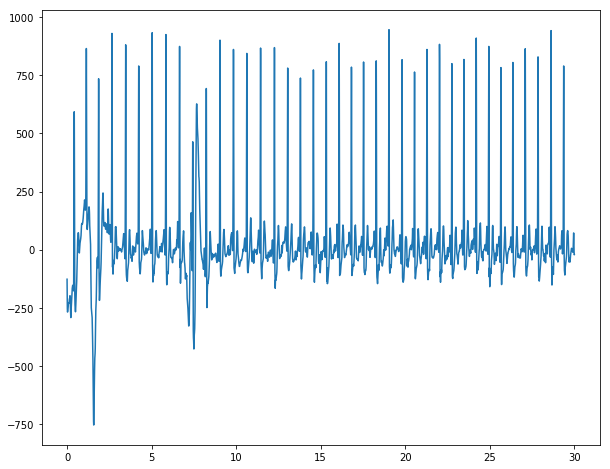

In [1]:
#Vamos a leer un par de ejemplo, así como la cabecera
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
from tfg_tools import read_challenge_mat_files, processing_ecg, plot_all_records

ecg, header = read_challenge_mat_files('A00001.mat','./')
fs = float(header['fs'])
t = np.arange(0,len(ecg))/fs 
plt.figure(figsize = (10,8))
plt.plot(t,ecg)

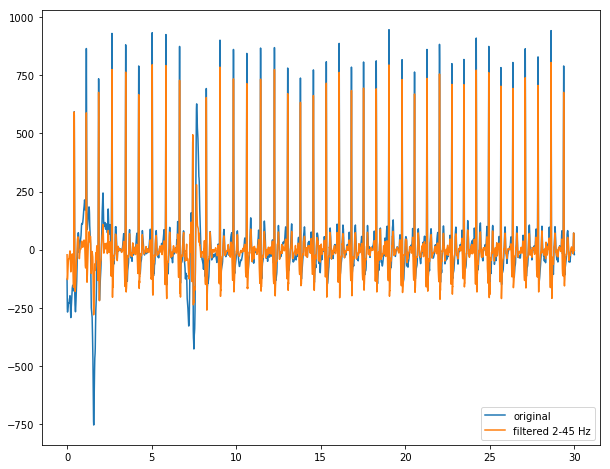

In [2]:
ecg_filtered = processing_ecg(ecg)

plt.figure(figsize = (10,8))
plt.plot(t,ecg,label='original')
plt.plot(t,ecg_filtered,label='filtered 2-45 Hz')
plt.legend()

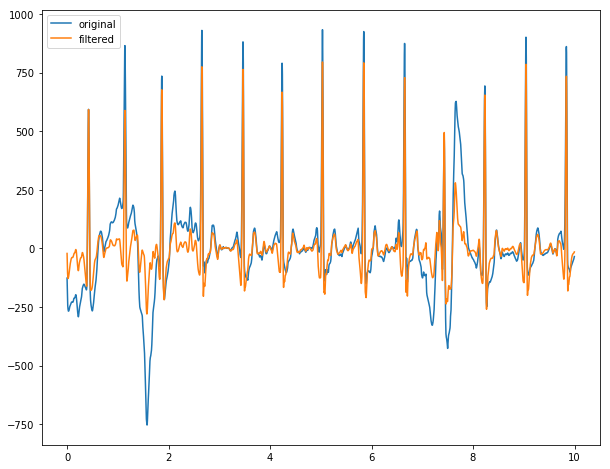

In [3]:
#zoom

plt.figure(figsize = (10,8))
plt.plot(t[t<10],ecg[t<10],label='original')
plt.plot(t[t<10],ecg_filtered[t<10],label='filtered')
plt.legend()

# Chapter Preprocesamiento y análisis exploratorio de señales

**TO DO**

* Crear una rutina que te pinte todas las señales. Un for que vaya pintando todas las señales y que se en la figura pinte información de los ejes (segundos y mv) y en la leyenda indique cómo ha sido clasificada la señal. Convendría pintar la señal original y la filtrada entre 2 y 45 Hz. Que no pase a la siguiente iteración del bucle hasta que, por ejemplo, se pulse un click de raton o alguna tecla.

* Sacar la siguiente información:
    * Número de sujetos en cada clase (esto lo puedes sacar del fichero en el que viene la clasificación de cada señal)
    * Longitudes de las señales: Una función que se cree un vector con todas las longitudes de todas las señales, y que pinte un histograma de las longitudes.
   
* Con esto podemos divisar los modeos de deep learning para clasificación


# NOTA:

<font color='red'>Miguel Ángel, lo que te pedía es que tu hicieses el análisis y completases este notebook con esa información, porque todo lo que escribas aquí, también se puede utilizar luego para la memoria</font>


### Número de sujetos en cada clase:

A continuación obtenemos el resultado de sujetos por cada clase:



In [4]:
#get the number of patietns in each class

from tfg_tools import get_distribution_classes

class_dist = get_distribution_classes()

print(class_dist)

{'A': 738, '~': 284, 'O': 2456, 'N': 5050}


Como se puede observar existe un claro desbalanceo: El caso de los registros normales es siete veces mayor que el caso de las señales con AF. Habrá que escoger alguna técnica de balanceado. Lo primero que recomendamos es echar un vistazo al siguiente post:

[Imbalanced classes](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/).

De las técnicas que tenemos en este caso, yo propondría varias, teniendo en cuenta que esto es un TFG:

1. Entrenar para mejorar otra métrica que accuracy, por ejemplo $\kappa$ o $F_1 score$.
2. Random over-sampling under-sampling: podemos utilizar el siguiente módulo (imbalanced-learning)(http://contrib.scikit-learn.org/imbalanced-learn/stable/index.html)
3. Utilizar costes diferentes dependiendo de la misclassification

### Longitudes de las señales

Un problema cuando trabajamos con modelos que no tengan en cuenta la parte dinámica es la diferente longitud de las señales. Vamos a obtener un histograma de las diferentes longitudes de señales, para tener una idea del rango de posibles longitudes, para proponer una estrategia cuando implementemos el modelo de deep learning sin memoria

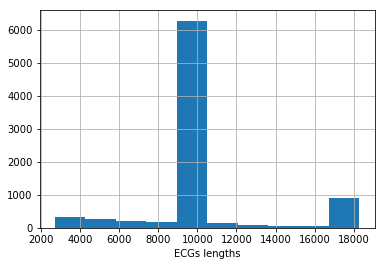

In [5]:
from tfg_tools import get_distribution_length

lengths = get_distribution_length()

In [6]:
#Número de señales con menos de 9000

print('El numero de senales con menos de 9000 es: ',np.sum(np.array(lengths)<9000))

('El numero de senales con menos de 9000 es: ', 967)


## TO-DO

Vamos a considerar **longitud de señales = 9000**, todas las que estén por debajo (967) no van a entrar en el conjunto, al menos en primera instancia. Necesitamos verificar de qué clase son las señales con menos de 9000. 

Tu próxima tarea es verificar las distribución por clases de esas 967 señales con menos de 9000. Para las que tienen más de 9000 muestras vamos a utilizar sólo las primeras 9000.

El problema lo resolver

In [7]:
from tfg_tools import get_distribution_less9000

classes_less_9000 = get_distribution_less9000()

print(classes_less_9000)



{'Normal': 521, 'Other Rhyth': 194, 'Noisy': 139, 'AF': 113}


Como podemos apreciar en los resultados de las señales con longitud menor de 9000, las señales normales son las más abundantes en comparanción con el resto. 

**Cuidado con estas afirmaciones Miguel Ángel** lo que dices es cierto, pero en valor absoluto, el problema es que no hay la misma cantidad inicial de datos, de hecho: AF113/783 = 0.19 approx 20%, mientras que Normal 521/5050 = 0.10 approx 10%

De esta manera podemose decir que, para el caso de una NN sin memoria, con señales de entrada de longitud 9000 muestras, vamos a tener la siguiente distribución:

* **AF** = 738 - 113 = **625**
* **Noisy** = 284 - 139 = **145**
* **Other** = 2456 - 194 = **2262**
* **Normal** = 5050 - 521 = **4529**


## TODO

Los siguientes pasos serían:

1. Partir convenientemente los datos en training y test, yo utilizaría alguna herramienta de sklearn para mantener las proporciones (de las clases) en test, hay herramientas como stratified.
2. Elegir alguna estrategia para comenzar con el tratamiento del desbalanceo: por ejemplo: under-sampling, over-sampling (aquí, vamos a utilizar el modulo que puse anteriormente, parecido a sklearn), y métrica.
3. Constuir un esquema sencillo de red neuronal, y luego complicarlo.

In [2]:
#Example of stratified split into train and test 

import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

x = np.ones(100)
y = [0,0,0,0,1,1,1,1,1,1] *10 #proportion of labels 6 out of 10 are class 1
y = np.array(y)

print (x)
print (y)

#split with previous shuffle. Test size = 33%

skf = StratifiedShuffleSplit(n_splits = 1,test_size = 0.33)

for train, test in skf.split(x,y):
    print("%s %s" % (train,test))


#let's check proportions

print("Proportion of class 1 in original dataset %.2f %%: " % (np.sum(y)/float(len(y))))
print("Proportion of class 1 in training dataset %.2f %%: " % (np.sum(y[train])/float(len(y[train]))))
print("Proportion of class 1 in test dataset %.2f %%: " % (np.sum(y[test])/float(len(y[test]))))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
[0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1
 1 1 1 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0 0 0 0
 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1]
(100,)
(100,)
[27 57 54 43 24 82  3 47 10  1 87 20 44 79  4 84 26 60 29 80 50 31 62 32
 11 36 49 13 39  9 95 63  5  0 88 71 35 34 55 58  8 77 46 81 48 76 91 68
  7 25 12 69 92 93 21 16 73 59 72 85 89 52 70 74 14 94 66] [ 2 78 17 28 97 61  6 56 18 19 42 90 45 51 67 15 99 65 30 83 53 40 98 41
 33 86 37 64 22 96 23 75 38]
Proportion of class 1 in original dataset 0.60 %: 
Proportion of class 1 in training dataset 0.60 %: 
Proportion of class 1 in test dataset 0.61 %: 


## Chapter : Modelos de redes neuronales

Vamos a comenzar utilizando una red neuronal ..

$$y(t) = \frac{1}{x}$$

## Sección: Separación en Training y Test

**Miguel Ángel, comenta aquí lo que vas a hacer para realizar la separación. En las celdas siguientes crea el código para realizarlo**

Dividimos los datos en training y test. Sólo se han considerado las señales de longitud 9000. Esta información se ha dividido en 80% para training y el 20% para test. Para la separación se ha utilizado la función StratifiedShuffleSplit. 


In [1]:
from tfg_tools import divide_data

divide_data()


[3195 1785 2159 4167  516 1639 5195 4006 5541  159 5072 3995 5796   83
 3510 2648 3193 3536 3009 3176 4142 5343 4301 1268 2660  812 1461  944
 1437 3613 2663 3221 3942 5855 1562 1359 2046 3739 3898  441  679  157
 2746 1779 4307 4382 4196 4817 2207 4299 4509 3736 1646 3979 4846 3120
 2736 5506 5951 3682 4092  427 1572 1666 1592  772 2922 3534 2098  655
  784 2546 4416 2948 2604 4772 4308 3200 1649 4898 3729 3426 5594 1547
 5378 4519  369 3683 2108 1167 2470 5745  972 3271   77 5581 3891  145
 2421  917 5609  683  759 3869 1772 2608 3212  628 5569 3429 5153 1633
 4760 1421 2137 3544 5379  633 3019 5385 2734  847  403 4166  134 5642
  290 3403 5520 5179 1027 3094 3618 4066 2401 1519 5429 1399 5730 3978
 1395 3967 5396 1075 5485  681 5226 1533 1936 3521  786 1454 1237 3741
  673  846 5414 4346 4977 2832 1045  151 1868 3762 4748 1015 1995 1279
 2687 1050 1643 4450 3213 2899 5664  123  826 1221 2191 3712  265 5107
 2543 1135 5227 3925 3747 2024 2984 2346  371 1910 4730 4064 3139 5193
 5246 